# Model accuracy, SHAP and feature selection using a threshold of 5 min APGAR < 7

In [1]:
threshold = 7 # Positive class is less than threshold

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

## Load and balance data

In [3]:
data = pd.read_csv('./data/processed_data_for_model_one_hot.csv')

In [4]:
prop_less_threshold = np.mean(data['apgar5'] < threshold)
print (f'Proportion < {threshold} = {prop_less_threshold:0.4f}')

Proportion < 7 = 0.0129


In [5]:
drop_hospitals = True

if drop_hospitals:
    selected_cols = []
    for col in list(data):
        if col[0:8] == 'hospital':
            pass
        else:
            selected_cols.append(col)
    
    data = data[selected_cols]

Balance data

In [6]:
mask = data['apgar5'] < threshold
pos_class = data[mask]
num_pos = len(mask)

mask = data['apgar5'] >= threshold
neg_class = data[mask]
num_neg = len(mask)

sample_size = max(num_neg, num_pos)

# resample
neg_class = neg_class.sample(sample_size, replace=True)
pos_class = pos_class.sample(sample_size, replace=True)

data = pd.concat([neg_class, pos_class], axis=0)
data = data.sample(frac=1.0, random_state=42, replace=False)
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)

Split X and y

In [7]:
y = data['apgar5'] < threshold
X = data.drop('apgar5', axis=1)

## K-fold accuracy measurement

In [8]:
# Set up splits
number_of_splits = 3
skf = StratifiedKFold(n_splits = number_of_splits)
skf.get_n_splits(X, y)

3

In [9]:
# Set up lists for observed and predicted
observed = []
predicted_proba = []
predicted = []
importances = []

# Loop through the k-fold splits
counter = 0
for train_index, test_index in skf.split(X, y):
    counter += 1
    
    # Get X and Y train/test
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # Fit model
    model = XGBClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Get predicted probabilities
    y_probs = model.predict_proba(X_test)[:,1]
    y_class = model.predict(X_test)
    observed.append(y_test)
    predicted_proba.append(y_probs)
    
    # Print accuracy
    tp = np.sum((y_class == 1) & (y_test == 1))
    fp = np.sum((y_class == 1) & (y_test == 0))
    tn = np.sum((y_class == 0) & (y_test == 0))
    fn = np.sum((y_class == 0) & (y_test == 1))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    accuracy = np.mean(y_class == y_test)
    print (
        f'Run {counter}, accuracy: {accuracy:0.3f}, sensitivity: {sensitivity:0.3f}, specificity: {specificity:0.3f}')

Run 1, accuracy: 0.809, sensitivity: 0.774, specificity: 0.844
Run 2, accuracy: 0.812, sensitivity: 0.781, specificity: 0.843
Run 3, accuracy: 0.804, sensitivity: 0.768, specificity: 0.841


In [10]:
# Set up lists for results
k_fold_fpr = [] # false positive rate
k_fold_tpr = [] # true positive rate
k_fold_thresholds = [] # threshold applied
k_fold_auc = [] # area under curve

# Loop through k fold predictions and get ROC results 
for i in range(number_of_splits):
    # Get fpr, tpr and thresholds foir each k-fold from scikit-learn's ROC method
    fpr, tpr, thresholds = roc_curve(observed[i], predicted_proba[i])
    # Use scikit-learn's method for calulcating auc
    roc_auc = auc(fpr, tpr)
    # Store results
    k_fold_fpr.append(fpr)
    k_fold_tpr.append(tpr)
    k_fold_thresholds.append(thresholds)
    k_fold_auc.append(roc_auc)
    # Print auc result
    print (f'Run {i} AUC {roc_auc:0.4f}')

# Show mean area under curve  
mean_auc = np.mean(k_fold_auc)
sd_auc = np.std(k_fold_auc)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')

Run 0 AUC 0.8900
Run 1 AUC 0.8916
Run 2 AUC 0.8871

Mean AUC: 0.8896
SD AUC: 0.0019


## SHAP

Fit SHAP to model, and show explainer for 25K sample.


In [11]:
model = XGBClassifier()
model.fit(X, y)


X_sample = X.sample(25000)
explainer = shap.TreeExplainer(model)
shap_values_extended = explainer(X_sample)
shap_values = explainer.shap_values(X_sample)
shap_values_extended[0]

.values =
array([-0.05431283,  0.0026765 ,  0.01317653, -0.00460886, -0.13964604,
       -0.10712828, -0.27858204, -0.02140347,  0.20883824,  0.00562059,
       -0.1458392 , -0.04932105, -0.37719086,  0.00449208, -0.00045736,
        0.00125157, -0.00227906, -0.00162194, -0.07082396,  0.01923792,
       -0.04266562,  0.00278475, -0.3495879 , -0.04385265, -0.01087746,
       -0.03068455, -0.0010984 , -0.02204599, -0.22673525, -0.00224802,
        0.00364166, -0.00269634,  0.0472436 ,  0.00383801,  0.        ,
       -0.03478228,  0.02389004,  0.01779589], dtype=float32)

.base_values =
0.010064628

.data =
array([1.0, 0.0, 2.0, False, False, 23, 32, 38, True, False, False, True,
       False, False, False, False, False, False, False, False, False,
       False, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
      dtype=object)

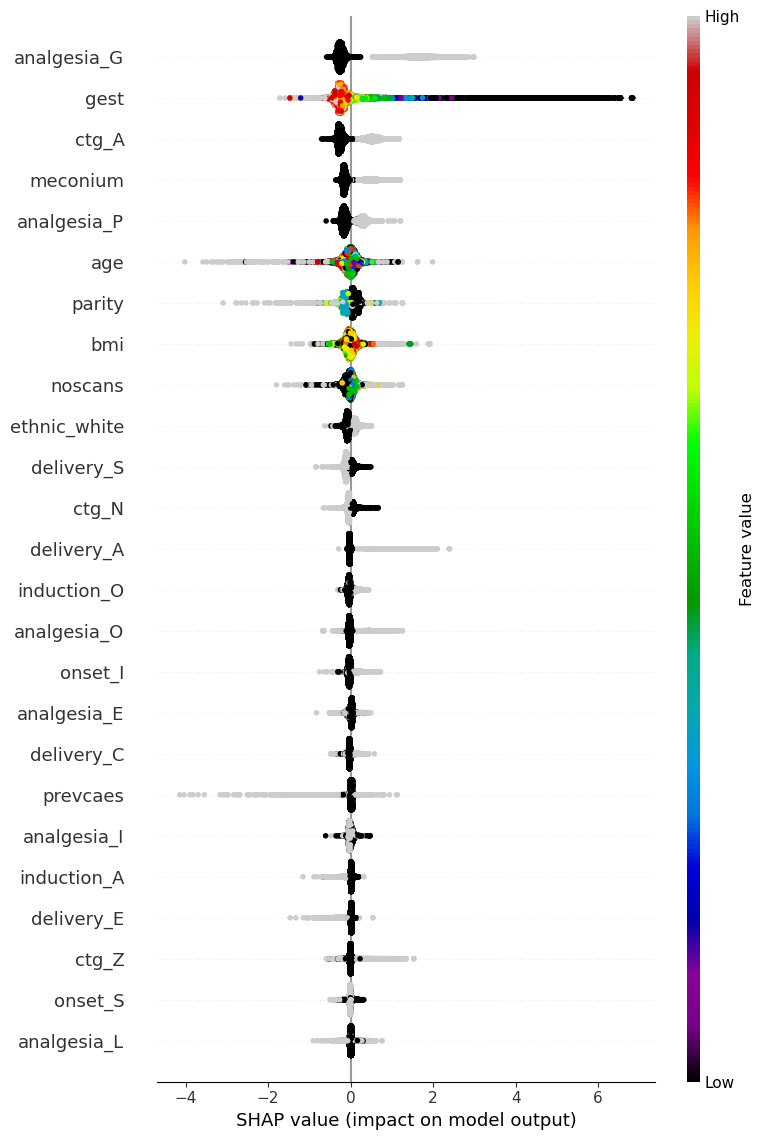

In [12]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values, 
                  features=X_sample,
                  feature_names=list(X_sample),
                  max_display=25,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)

plt.savefig(f'./output/shap_beeswarm_threshold_{threshold}.jpg', dpi=300)
plt.show()

In [13]:
df = pd.DataFrame(index=list(X))
df['feature_index'] = np.arange(len(list(X)))
df['mean_shap'] = np.mean(shap_values, axis=0)
df['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
df.sort_values('mean_abs_shap', ascending=False, inplace=True)

top_shap = list(df.index)
df.head(10)

,feature_index,mean_shap,mean_abs_shap
analgesia_G,12,0.120316,0.513543
gest,7,0.127565,0.491021
ctg_A,22,0.000523,0.340419
meconium,4,-0.008304,0.225226
analgesia_P,10,-0.006558,0.192135
age,6,-0.027002,0.141385
parity,0,-0.005324,0.124596
bmi,5,-0.018130,0.110454
noscans,2,-0.009479,0.104248
ethnic_white,8,-0.005257,0.091912


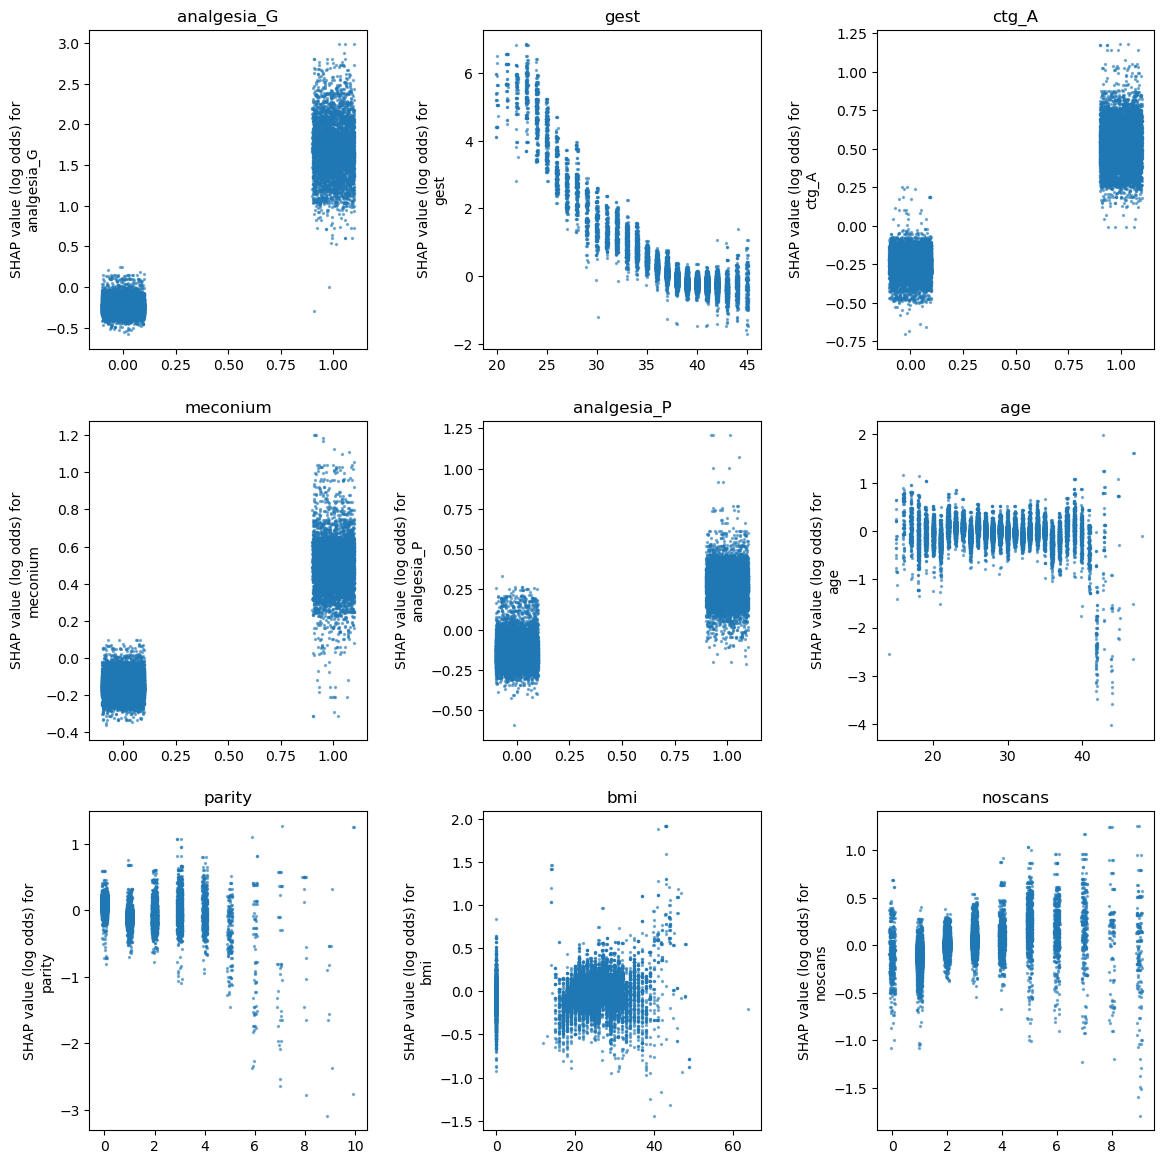

In [14]:
feat_to_show = top_shap[0:9]

fig = plt.figure(figsize=(12,12))
for n, feat in enumerate(feat_to_show):
    feat_index = int(df.loc[feat]['feature_index']) 
    ax = fig.add_subplot(3,3,n+1)

    shap_data = shap_values_extended[:].values[:,feat_index]
    feature_data = shap_values_extended[:].data[:,feat_index]

    jitter = -0.1 + (np.random.rand(len(feature_data))*0.2)

    ax.scatter(feature_data + jitter, shap_data, alpha=0.5, s=2)
  
    
    ax.set_ylabel(f'SHAP value (log odds) for\n{feat}')
    ax.set_title(feat)
    
plt.tight_layout(pad=2)
plt.savefig(f'./output/shap_scatter_threshold_{threshold}.jpg', dpi=300)

plt.show()


## Feature selection

In [15]:
# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
roc_auc_by_feature_number_kfold = []
chosen_features = []
best_auc = 0

# Initialise chosen features list and run tracker
available_features = list(X)
number_of_features = len(available_features)

# Loop through number of features
for i in range (20):
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''
    
    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        
        # Set up a list to hold AUC results for this feature for each kfold
        feature_roc_auc_kfold = []
        
        # Loop through the k-fold splits
        counter = 0
        for train_index, test_index in skf.split(X, y):
            counter += 1
    
            # Get X and Y train/test
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y.loc[train_index], y.loc[test_index]            
            
            # Restrict features
            X_train = X_train[features_to_use]
            X_test = X_test[features_to_use]

            # Define model
            model = XGBClassifier(random_state=42)

            # Fit model
            model.fit(X_train, y_train)
            
            # Get predicted probabilities
            y_probs = model.predict_proba(X_test)[:,1]
            y_class = model.predict(X_test)
            
            fpr, tpr, thresholds = roc_curve(y_test, y_probs)
            # Use scikit-learn's method for calulcating auc
            roc_auc = auc(fpr, tpr)

            feature_roc_auc_kfold.append(roc_auc)

            # Remove model
            del model
        
        # Get average result from all k-fold splits``
        feature_auc_mean = np.mean(feature_roc_auc_kfold)
    
        # Update chosen feature and result if this feature is a new best
        if feature_auc_mean > best_result:
            best_result = feature_auc_mean
            best_result_kfold = feature_roc_auc_kfold
            best_feature = feature
            
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_result)
    roc_auc_by_feature_number_kfold.append(best_result_kfold)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)
            
    print (f'Feature {i+1:2.0f}: {best_feature}, AUC: {best_result:0.3f}')

Feature  1: delivery_S, AUC: 0.641
Feature  2: gest, AUC: 0.712
Feature  3: ctg_A, AUC: 0.745
Feature  4: age, AUC: 0.774
Feature  5: bmi, AUC: 0.805
Feature  6: analgesia_G, AUC: 0.827
Feature  7: noscans, AUC: 0.840
Feature  8: analgesia_P, AUC: 0.846
Feature  9: meconium, AUC: 0.854
Feature 10: parity, AUC: 0.861
Feature 11: analgesia_I, AUC: 0.866
Feature 12: ethnic_white, AUC: 0.868
Feature 13: onset_S, AUC: 0.873
Feature 14: analgesia_O, AUC: 0.875
Feature 15: analgesia_L, AUC: 0.877
Feature 16: induction_O, AUC: 0.879
Feature 17: analgesia_E, AUC: 0.883
Feature 18: delivery_V, AUC: 0.884
Feature 19: induction_A, AUC: 0.886
Feature 20: induction_P, AUC: 0.887


In [16]:
s = pd.Series(chosen_features)
s.to_csv('./output/feature_selection_threshold_{threshold}.csv', header=False)